# Generative Adversarial Network

## Pre-processing data

In [1]:
import tensorflow as tf
import numpy as np
from IPython.display import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import cv2
tf.reset_default_graph()

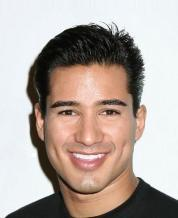

In [2]:
Image("img_align_celeba/000214.jpg") 

In [3]:
    
## Here we will get the 100 000 first images and put them in a variable 178*218*3
data_size = 25001
def get_data(data_size=25001):
        dataset = []
        for x in range(1, data_size):
            imgname = "img_align_celeba_64/"
            imgname += str(x) + ".jpg"
            dataset.append(mpimg.imread(imgname))
        dataset =  np.reshape(np.array(dataset), (len(dataset), 64,64,3))
        dataset = np.reshape(dataset[:,...], (dataset.shape[0], 64*64*3))
        return dataset
    
def get_data_normalized(data_size=25001):
        dataset = []
        for x in range(1, data_size):
            imgname = "img_align_celeba_64/" + str(x).zfill(6) + ".jpg"
            dataset.append(mpimg.imread(imgname))
        dataset =  np.array(dataset)/255.0
        dataset = np.reshape(dataset, (dataset.shape[0], 64,64,3))
        ## HSV
        #hsv = cv2.cvtColor(mpimg.imread(imgname), cv2.COLOR_BGR2HSV)
        #dataset.append(hsv)
        #dataset =  np.array(dataset)/255.
        print("Data loaded. Number of images: " + str(data_size))
        return dataset
        
def get_batch(batch_size, dataset):
        indexes = np.random.randint(0, len(dataset), batch_size)
        data = dataset[indexes]
        return data

def sample_Z(batch_size=50, n=100):
        return np.random.uniform(-1., 1., size=[batch_size, n])

In [4]:

## HSV print image
#dat = get_data_normalized(5)

#dat = (dat * 255).astype(np.uint8)
#print(dat[2])
#im = cv2.cvtColor(dat[0], cv2.COLOR_HSV2BGR)
#cv2.imshow('image', im)
#cv2.waitKey(0)
#cv2.destroyAllWindows()
#plt.imshow(im)

In [5]:
def generator_mlp(Z, fc_sizes=[110,200,300], output_dim=64*64*3, reuse=False):
    
    with tf.variable_scope("Generator",reuse=reuse):
        fc1 = tf.layers.dense(Z, fc_sizes[0], activation=tf.nn.leaky_relu)
        fc2 = tf.layers.dense(fc1, fc_sizes[1], activation=tf.nn.leaky_relu)
        fc3 = tf.layers.dense(fc2, fc_sizes[2], activation=tf.nn.leaky_relu)
        out0 = tf.layers.dense(fc3, output_dim)
        out = tf.reshape(out0, (-1, 64,64,3))
    return out

def generator_mlp2(Z, fc_sizes=[200,500,700]):
    
    with tf.variable_scope("Generator",reuse=False):
        fc1 = tf.layers.dense(Z, fc_sizes[0])
        bn1 = tf.layers.batch_normalization(fc1, training=True)
        relu1 = tf.nn.relu(bn1)

        fc2 = tf.layers.dense(relu1, fc_sizes[1])
        bn2 = tf.layers.batch_normalization(fc2, training=True)
        relu2 = tf.nn.relu(bn2)
        
        fc3 = tf.layers.dense(relu2, fc_sizes[2])
        bn3 = tf.layers.batch_normalization(fc3, training=True)
        relu3 = tf.nn.relu(bn3)
        
        out = tf.layers.dense(relu3, 64*64*3)
        out2 = tf.nn.tanh(out)
        out3 = tf.reshape(out2, (-1, 64, 64, 3))
    return out3

def generator_cnn(Z):
    
    with tf.variable_scope("Generator",reuse=False):      
         # 1. Fully connnected
        fc = tf.layers.dense(Z, 8*8*128)
        fc = tf.reshape(fc, (-1, 8, 8, 128))
        bn0 = tf.layers.batch_normalization(fc, training=True)
        relu0 = tf.nn.relu(bn0)

        # 2. Deconvolution 
        conv1 = tf.layers.conv2d_transpose(relu0, 64, 5, 2, 'same')
        bn1 = tf.layers.batch_normalization(conv1, training=True)
        relu1 = tf.nn.relu(bn1)

        # 3. Deconvolution
        conv2 = tf.layers.conv2d_transpose(relu1, 32, 5, 2, 'same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.nn.relu(bn2)

        # 5. dense, Output layer
        out = tf.layers.conv2d_transpose(relu2, 3, 5, 2, 'same')
        
        return tf.nn.sigmoid(out)


In [6]:
def discriminator_mlp(X, fc_sizes=[110,300,200], reuse=False):
    
    with tf.variable_scope("Discriminator",reuse=reuse):
        XX =tf.reshape(X, (-1, 64*64*3))
        h1 = tf.layers.dense(XX,fc_sizes[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,fc_sizes[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,fc_sizes[2],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h3,1)

    return out

def discriminator_mlp2(X, fc_sizes=[600,400,200], alpha = 0.01, reuse=False):
    
    with tf.variable_scope("Discriminator",reuse=reuse):
        XX =tf.reshape(X, (-1, 64*64*3))
        h1 = tf.layers.dense(XX,fc_sizes[0])
        bn1 = tf.layers.batch_normalization(h1, training=True)
        lrelu1 = tf.maximum(alpha * bn1, bn1)

        
        h2 = tf.layers.dense(lrelu1,fc_sizes[1])
        bn2 = tf.layers.batch_normalization(h2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)

        
        h3 = tf.layers.dense(lrelu2,fc_sizes[2])
        bn3 = tf.layers.batch_normalization(h3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)

        
        out = tf.layers.dense(lrelu3,1)
        ou2 = tf.nn.sigmoid(out)

    return out

def discriminator_cnn(X, reuse=False, alpha=0.05):
    
    with tf.variable_scope("Discriminator",reuse=reuse):
        # Input layer is 64x64x3
        # Convolutional layer, 30x30x64
        conv1 = tf.layers.conv2d(X, 32, 5, 2, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu1 = tf.maximum(alpha * conv1, conv1)

        # Strided convolutional layer, 13x13x128
        conv2 = tf.layers.conv2d(lrelu1, 64, 5, 2, 'valid')
        bn2 = tf.layers.batch_normalization(conv2)
        lrelu2 = tf.maximum(alpha * bn2, bn2)

        # Strided convolutional layer, 5x5x256
        conv3 = tf.layers.conv2d(lrelu2, 128, 5, 2, 'valid')
        bn3 = tf.layers.batch_normalization(conv3)
        lrelu3 = tf.maximum(alpha * bn3, bn3)


        # fully connected
        flat = tf.reshape(lrelu3, (-1, 128))
        out = tf.layers.dense(flat, 1)

        
        return out

In [7]:
X = tf.placeholder(tf.float32,[None,64,64,3])
Z = tf.placeholder(tf.float32,[None,60])

In [8]:
X_fake = generator_cnn(Z)
true_data_logits = discriminator_cnn(X)
fake_data_logits = discriminator_cnn(X_fake, reuse=True)

In [9]:
D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_data_logits,labels=tf.ones_like(true_data_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_data_logits,labels=tf.zeros_like(fake_data_logits)))
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_data_logits,labels=tf.ones_like(fake_data_logits)))


In [10]:
G_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Generator")
D_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Discriminator")

G_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(G_loss,var_list = G_variables) # G Train step
D_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(D_loss,var_list = D_variables) # D Train step

#G_step = tf.train.AdamOptimizer(learning_rate=0.002, beta1=0.5, beta2=0.8).minimize(G_loss,var_list = G_variables)
#D_step = tf.train.AdamOptimizer(learning_rate=0.002, beta1=0.5, beta2=0.8).minimize(D_loss,var_list = D_variables)

In [68]:
#sess = tf.Session()
print("initializing variables...")
#tf.global_variables_initializer().run(session=sess)
print("variable initialization done")


batch_size = 32

print("Loading data...")
dataset = get_data_normalized(4000)
print("Data loaded. Number of images: " + str(len(dataset)))

for i in range(2000):
    X_batch = get_batch(batch_size, dataset)
    Z_batch = sample_Z(batch_size, 60)
    _, Dloss = sess.run([D_step, D_loss], feed_dict={X: X_batch, Z: Z_batch})
    _, Gloss = sess.run([G_step, G_loss], feed_dict={Z: Z_batch})

    print("N: %d\t D_loss: %.4f\t G_loss: %.4f"%(i,Dloss,Gloss))
Z_batch = sample_Z(1, 60)
X_batch = get_batch(1, dataset)


# RGB
sess.run(X_fake, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(X_fake, shape=(64,64,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

## HSV
#image = tf.reshape(G_sample, shape=(64,64,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch})
#image = (image * 255).astype(npint)
#im = cv2.cvtColor(dat[0], cv2.COLOR_HSV2BGR)
#plt.imshow(im)

initializing variables...
variable initialization done
Loading data...
Data loaded. Number of images: 4000
Data loaded. Number of images: 3999
N: 0	 D_loss: 1.3843	 G_loss: 0.7053
N: 1	 D_loss: 1.3919	 G_loss: 0.7642
N: 2	 D_loss: 1.3882	 G_loss: 0.7085
N: 3	 D_loss: 1.3880	 G_loss: 0.6997
N: 4	 D_loss: 1.3858	 G_loss: 0.7075
N: 5	 D_loss: 1.3823	 G_loss: 0.7183
N: 6	 D_loss: 1.3814	 G_loss: 0.6963
N: 7	 D_loss: 1.3826	 G_loss: 0.6929
N: 8	 D_loss: 1.3712	 G_loss: 0.6532
N: 9	 D_loss: 1.4143	 G_loss: 0.7413
N: 10	 D_loss: 1.3752	 G_loss: 0.7258
N: 11	 D_loss: 1.4112	 G_loss: 0.7659
N: 12	 D_loss: 1.3892	 G_loss: 0.7243
N: 13	 D_loss: 1.3805	 G_loss: 0.7104
N: 14	 D_loss: 1.3836	 G_loss: 0.6812
N: 15	 D_loss: 1.3899	 G_loss: 0.7111
N: 16	 D_loss: 1.3875	 G_loss: 0.6976
N: 17	 D_loss: 1.3853	 G_loss: 0.7064
N: 18	 D_loss: 1.3819	 G_loss: 0.6956
N: 19	 D_loss: 1.3801	 G_loss: 0.6907
N: 20	 D_loss: 1.3664	 G_loss: 0.7016
N: 21	 D_loss: 1.3939	 G_loss: 0.7524
N: 22	 D_loss: 1.3863	 G_loss: 

N: 210	 D_loss: 1.3776	 G_loss: 0.6924
N: 211	 D_loss: 1.3757	 G_loss: 0.7223
N: 212	 D_loss: 1.3883	 G_loss: 0.7125
N: 213	 D_loss: 1.3826	 G_loss: 0.7226
N: 214	 D_loss: 1.3835	 G_loss: 0.7395
N: 215	 D_loss: 1.3705	 G_loss: 0.6945
N: 216	 D_loss: 1.3770	 G_loss: 0.6930
N: 217	 D_loss: 1.3842	 G_loss: 0.7213
N: 218	 D_loss: 1.3900	 G_loss: 0.7374
N: 219	 D_loss: 1.3828	 G_loss: 0.7060
N: 220	 D_loss: 1.3755	 G_loss: 0.6991
N: 221	 D_loss: 1.3820	 G_loss: 0.7038
N: 222	 D_loss: 1.3831	 G_loss: 0.7148
N: 223	 D_loss: 1.3844	 G_loss: 0.7179
N: 224	 D_loss: 1.3814	 G_loss: 0.7323
N: 225	 D_loss: 1.3827	 G_loss: 0.7026
N: 226	 D_loss: 1.3765	 G_loss: 0.7067
N: 227	 D_loss: 1.3826	 G_loss: 0.7075
N: 228	 D_loss: 1.3759	 G_loss: 0.6961
N: 229	 D_loss: 1.3848	 G_loss: 0.7363
N: 230	 D_loss: 1.3829	 G_loss: 0.7150
N: 231	 D_loss: 1.3851	 G_loss: 0.6932
N: 232	 D_loss: 1.3767	 G_loss: 0.7447
N: 233	 D_loss: 1.3838	 G_loss: 0.6972
N: 234	 D_loss: 1.3775	 G_loss: 0.7161
N: 235	 D_loss: 1.3849	 G

N: 421	 D_loss: 1.3846	 G_loss: 0.7099
N: 422	 D_loss: 1.3849	 G_loss: 0.6953
N: 423	 D_loss: 1.3762	 G_loss: 0.7227
N: 424	 D_loss: 1.3763	 G_loss: 0.7313
N: 425	 D_loss: 1.3733	 G_loss: 0.7197
N: 426	 D_loss: 1.3849	 G_loss: 0.7291
N: 427	 D_loss: 1.3776	 G_loss: 0.6910
N: 428	 D_loss: 1.3901	 G_loss: 0.7212
N: 429	 D_loss: 1.3813	 G_loss: 0.7125
N: 430	 D_loss: 1.3773	 G_loss: 0.6866
N: 431	 D_loss: 1.3835	 G_loss: 0.7615
N: 432	 D_loss: 1.3929	 G_loss: 0.7146
N: 433	 D_loss: 1.3811	 G_loss: 0.7054
N: 434	 D_loss: 1.3790	 G_loss: 0.6828
N: 435	 D_loss: 1.3736	 G_loss: 0.6786


KeyboardInterrupt: 

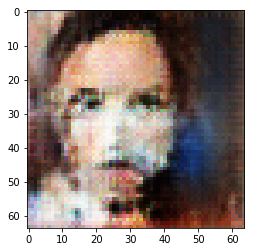

In [91]:
Z_batch = sample_Z(1, 60)
img = tf.reshape(X_fake, shape=(64,64,3)).eval(session=sess, feed_dict={Z: Z_batch})
plt.imshow(img)

In [88]:
for i in range(100):
    Z_batch = sample_Z(1, 60)
    img = tf.reshape(X_fake, shape=(64,64,3)).eval(session=sess, feed_dict={Z: Z_batch})[...,::-1]
    cv2.imwrite("img/all_cnn/"+ str(i).zfill(3) +".jpg", (img+1)/2*255)

In [46]:
cv2.imwrite("img/all/"+ str(1).zfill(3) +".jpg", cv2.resize((img+1)/2*255, (400,400)))

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


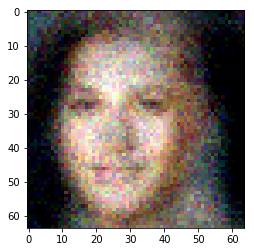

In [43]:
Z_batch = sample_Z(1, 60)
X_batch = get_batch(1, dataset)
img = tf.reshape(X_fake, shape=(64,64,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


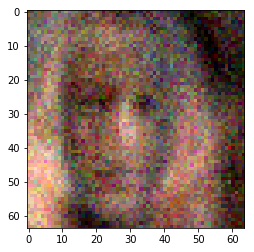

In [39]:
Z_batch = sample_Z(1, 60)
img = tf.reshape(X_fake, shape=(64,64,3)).eval(session=sess, feed_dict={Z: Z_batch})
plt.imshow(img)

In [40]:
saver = tf.train.Saver()
save_path = saver.save(sess, "tmp/test.ckpt")

In [13]:
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "tmp/test.ckpt")

INFO:tensorflow:Restoring parameters from tmp/test.ckpt
